In [2]:
!pip install torchinfo

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch import Tensor
from enum import Enum
from torchinfo import summary

## Model Code


In [5]:
NUM_GROUPS: int = 8
DROPOUT: float = 0.05


class NormalizationMethod(Enum):
    BATCH = 1
    LAYER = 2
    GROUP = 3


def normalizer(
    method: NormalizationMethod,
    out_channels: int,
) -> nn.BatchNorm2d | nn.GroupNorm:
    if method is NormalizationMethod.BATCH:
        return nn.BatchNorm2d(out_channels)
    elif method is NormalizationMethod.LAYER:
        return nn.GroupNorm(1, out_channels)
    elif method is NormalizationMethod.GROUP:
        return nn.GroupNorm(NUM_GROUPS, out_channels)
    else:
        raise ValueError("Invalid NormalizationMethod")


class ConvBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        num_layers: int,
        padding: int = 1,
        norm_method: NormalizationMethod = NormalizationMethod.BATCH,
        add_skip: bool = False,
    ):
        """Initialize Block [with num_layers ConvLayers]

        Args:
            in_channels (int): Input Channel Size
            out_channels (int): Output Channel Size
            padding (int, optional): Padding to be used for convolution layer. Defaults to 1.
            norm_method (enum, optional): Type of normalization to be used. Defaults to NormalizationMethod.BATCH
        """
        super(ConvBlock, self).__init__()

        self.block = nn.Sequential(
            *[
                ConvLayer(
                    in_channels=(in_channels if i == 0 else out_channels),
                    out_channels=out_channels,
                    padding=padding,
                    norm_method=norm_method,
                    add_skip=add_skip,
                )
                for i in range(num_layers)
            ]
        )

    def forward(self, x):
        """
        Args:
            x (tensor): Input tensor to this block

        Returns:
            tensor: Return processed tensor
        """
        x = self.block(x)
        return x


class ConvLayer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        padding: int = 1,
        norm_method: NormalizationMethod = NormalizationMethod.BATCH,
        add_skip: bool = False,
    ):
        """Initialize Layer [conv(3,3) + normalization + relu]

        Args:
            in_channels (int): Input Channel Size
            out_channels (int): Output Channel Size
            padding (int, optional): Padding to be used for convolution layer. Defaults to 1.
            norm_method (enum, optional): Type of normalization to be used. Defaults to NormalizationMethod.BATCH
        """
        super(ConvLayer, self).__init__()

        self.add_skip = add_skip
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            padding=padding,
            bias=False,
        )
        self.norm = normalizer(method=norm_method, out_channels=out_channels)
        self.activation = nn.ReLU()
        self.drop = nn.Dropout(DROPOUT)

    def forward(self, x):
        """
        Args:
            x (tensor): Input tensor to this block

        Returns:
            tensor: Return processed tensor
        """
        y = x
        x = self.conv(x)
        x = self.norm(x)
        if self.add_skip:
            x = x + y
        x = self.activation(x)
        x = self.drop(x)
        return x


class TransBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
    ):
        """Initialize Transition block [conv (1,1) + max pooling]

        Args:
            in_channels (int): Input Channel Size
            out_channels (int): Output Channel Size
        """
        super(TransBlock, self).__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=(1, 1),
                bias=False,
            ),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
        )

    def forward(self, x):
        """
        Args:
            x (tensor): Input tensor to this block

        Returns:
            tensor: Return processed tensor
        """
        x = self.layer(x)
        return x


class S08Model(nn.Module):
    def __init__(
        self,
        norm_method: NormalizationMethod = NormalizationMethod.BATCH,
        add_skip: bool = False,
    ) -> None:
        super(S08Model, self).__init__()

        self.conv_block1 = ConvBlock(
            in_channels=3,
            out_channels=24,
            num_layers=2,
            padding=1,
            norm_method=norm_method,
            add_skip=False,
        )
        self.trans_block1 = TransBlock(in_channels=24, out_channels=16)

        self.conv_block2 = ConvBlock(
            in_channels=16,
            out_channels=24,
            num_layers=3,
            padding=1,
            norm_method=norm_method,
            add_skip=add_skip,
        )
        self.trans_block2 = TransBlock(in_channels=24, out_channels=16)

        self.conv_block3 = ConvBlock(
            in_channels=16,
            out_channels=24,
            num_layers=3,
            padding=1,
            norm_method=norm_method,
            add_skip=add_skip,
        )

        self.output_block = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), bias=False),
            nn.Flatten(),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x: Tensor):
        x = self.conv_block1(x)
        x = self.trans_block1(x)
        x = self.conv_block2(x)
        x = self.trans_block2(x)
        x = self.conv_block3(x)
        x = self.output_block(x)

        return x



## Training

In [6]:
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau


class Trainer:
    def __init__(self, model, train_loader, optimizer, criterion, device) -> None:
        self.losses = []
        self.accuracies = []
        self.epoch_accuracies = []
        self.model = model.to(device)
        self.train_loader = train_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.lr_history = []

    def train(self, epoch, use_l1=False, lambda_l1=0.01):
        self.model.train()

        lr_trend = []
        correct = 0
        processed = 0
        train_loss = 0

        pbar = tqdm(self.train_loader)

        for batch_id, (inputs, targets) in enumerate(pbar):
            # transfer to device
            inputs, targets = inputs.to(self.device), targets.to(self.device)

            # Initialize gradients to 0
            self.optimizer.zero_grad()

            # Prediction
            outputs = self.model(inputs)

            # Calculate loss
            loss = self.criterion(outputs, targets)

            l1 = 0
            if use_l1:
                for p in self.model.parameters():
                    l1 = l1 + p.abs().sum()
            loss = loss + lambda_l1 * l1

            self.losses.append(loss.item())

            # Backpropagation
            loss.backward()
            self.optimizer.step()

            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(targets.view_as(pred)).sum().item()
            processed += len(inputs)

            pbar.set_description(
                desc=f"EPOCH = {epoch} | LR = {self.optimizer.param_groups[0]['lr']} | Loss = {loss.item():3.2f} | Batch = {batch_id} | Accuracy = {100*correct/processed:0.2f}"
            )
            self.accuracies.append(100 * correct / processed)

        # After all the batches are done, append accuracy for epoch
        self.epoch_accuracies.append(100 * correct / processed)

        self.lr_history.extend(lr_trend)
        return 100 * correct / processed, train_loss / len(self.train_loader), lr_trend


## Testing

In [7]:
from typing import List
import torch
from torch import Tensor


class Tester:
    def __init__(self, model, test_loader, criterion, device) -> None:
        self.losses = []
        self.accuracies = []
        self.model = model.to(device)
        self.test_loader = test_loader
        self.criterion = criterion
        self.device = device

    def test(self):
        self.model.eval()

        test_loss = 0
        correct = 0

        with torch.no_grad():
            for inputs, targets in self.test_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                output = self.model(inputs)
                loss = self.criterion(output, targets)

                test_loss += loss.item()

                pred = output.argmax(
                    dim=1, keepdim=True
                )  # get the index of the max log-probability
                correct += pred.eq(targets.view_as(pred)).sum().item()

        test_loss /= len(self.test_loader.dataset)
        self.losses.append(test_loss)

        print(
            "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
                test_loss,
                correct,
                len(self.test_loader.dataset),
                100.0 * correct / len(self.test_loader.dataset),
            )
        )

        self.accuracies.append(100.0 * correct / len(self.test_loader.dataset))

        return 100.0 * correct / len(self.test_loader.dataset), test_loss

    def get_misclassified_images(self):
        self.model.eval()

        images: List[Tensor] = []
        predictions = []
        labels = []

        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)

                output = self.model(data)

                _, preds = torch.max(output, 1)

                for i in range(len(preds)):
                    if preds[i] != target[i]:
                        images.append(data[i])
                        predictions.append(preds[i])
                        labels.append(target[i])

        return images, predictions, labels


## Utils

In [8]:
from math import sqrt, floor, ceil
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
from torch import Tensor

def denormalize(img):
    channel_means = (0.4914, 0.4822, 0.4465)
    channel_stdevs = (0.2470, 0.2435, 0.2616)
    img = img.astype(dtype=np.float32)

    for i in range(img.shape[0]):
        img[i] = (img[i] * channel_stdevs[i]) + channel_means[i]

    return np.transpose(img, (1, 2, 0))


def get_rows_cols(num: int) -> Tuple[int, int]:
    cols = floor(sqrt(num))
    rows = ceil(num / cols)

    return rows, cols


def visualize_data(
    loader,
    num_figures: int = 12,
    label: str = "",
    classes: List[str] = [],
):
    batch_data, batch_label = next(iter(loader))

    fig = plt.figure()
    fig.suptitle(label)

    rows, cols = get_rows_cols(num_figures)

    for i in range(num_figures):
        plt.subplot(rows, cols, i + 1)
        plt.tight_layout()
        npimg = denormalize(batch_data[i].cpu().numpy().squeeze())
        label = (
            classes[batch_label[i]] if batch_label[i] < len(classes) else batch_label[i]
        )
        plt.imshow(npimg, cmap="gray")
        plt.title(label)
        plt.xticks([])
        plt.yticks([])


def show_misclassified_images(
    images: List[Tensor],
    predictions: List[int],
    labels: List[int],
    classes: List[str],
    label: str = "",
):
    assert len(images) == len(predictions) == len(labels)

    fig = plt.figure(figsize=(5, 12))
    fig.suptitle(label)

    for i in range(len(images)):
        plt.subplot(len(images) // 2, 2, i + 1)
        plt.tight_layout()
        image = images[i]
        npimg = denormalize(image.cpu().numpy().squeeze())
        predicted = classes[predictions[i]]
        correct = classes[labels[i]]
        plt.imshow(npimg, cmap="gray")
        plt.title("Correct: {}\nPredicted: {}".format(correct, predicted))
        plt.xticks([])
        plt.yticks([])


def plot_data(data_list: List[List[int | float]], titles: List[str]):
    assert len(data_list) == len(
        titles
    ), "length of datalist should be equal to length of title list"

    rows, cols = get_rows_cols(len(data_list))

    fig, axs = plt.subplots(rows, cols, figsize=(15, 10))

    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j

            if idx >= len(data_list):
                break

            ax = axs[i, j] if len(axs.shape) > 1 else axs[max(i, j)]

            ax.plot(data_list[idx])  # type: ignore
            ax.set_title(titles[idx])


def collect_results(trainer: Trainer, tester: Tester):
    return {
        "train_losses": trainer.losses,
        "train_accuracies": trainer.accuracies,
        "test_losses": tester.losses,
        "test_accuracies": tester.accuracies,
    }


## Data Loading

In [9]:
from typing import Any, Callable, List, Optional
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np


class Cifar10DataLoader:
    def __init__(self, batch_size=128, is_cuda_available=False) -> None:
        self.batch_size: int = batch_size
        self.means: List[float] = [0.4914, 0.4822, 0.4465]
        self.stds: List[float] = [0.2470, 0.2435, 0.2616]

        self.dataloader_args = {"shuffle": True, "batch_size": self.batch_size}
        if is_cuda_available:
            self.dataloader_args["num_workers"] = 2
            self.dataloader_args["pin_memory"] = True

        self.classes: List[str] = [
            "plane",
            "car",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
        ]

    def get_dataset(
        self,
        transforms: Optional[Callable],
        train=True,
        data_dir: str = "../data",
    ):
        return datasets.CIFAR10(
            data_dir,
            train=train,
            transform=transforms,
            download=True,
        )

    def get_loader(self, transforms: Optional[Callable], train=True):
        return DataLoader(
            dataset=self.get_dataset(transforms=transforms, train=train),
            **self.dataloader_args,
        )

    def get_classes(self):
        return self.classes

## Main code

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [14]:
print("Is CUDA available? ", use_cuda)

Is CUDA available?  True


In [13]:
train_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2470, 0.2435, 0.2616),
        ),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2470, 0.2435, 0.2616),
        ),
    ]
)

In [15]:
cifar10 = Cifar10DataLoader(is_cuda_available=use_cuda)

train_loader = cifar10.get_loader(transforms=train_transforms, train=True)
test_loader = cifar10.get_loader(transforms=test_transforms, train=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 47939411.94it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


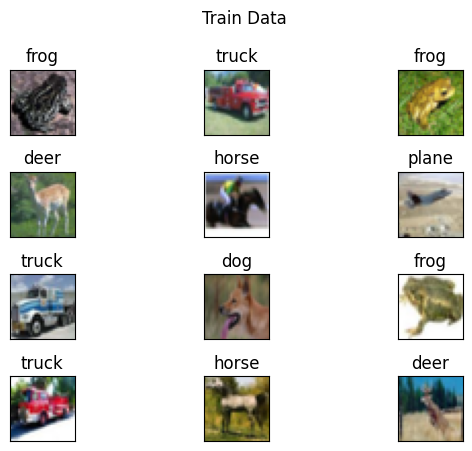

In [16]:
visualize_data(train_loader, 12, "Train Data", classes=cifar10.classes)

In [17]:
model = S08Model(norm_method=NormalizationMethod.LAYER, add_skip=False).to(device)
batch_size = 2
summary(
    model,
    input_size=(batch_size, 3, 32, 32),
    depth=4,
    col_width=18,
    col_names=[
        "kernel_size",
        "input_size",
        "output_size",
        "num_params",
        "trainable",
    ],
    row_settings=["var_names"],
)

Layer (type (var_name))                  Kernel Shape       Input Shape        Output Shape       Param #            Trainable
S08Model (S08Model)                      --                 [2, 3, 32, 32]     [2, 10]            --                 True
├─ConvBlock (conv_block1)                --                 [2, 3, 32, 32]     [2, 24, 32, 32]    --                 True
│    └─Sequential (block)                --                 [2, 3, 32, 32]     [2, 24, 32, 32]    --                 True
│    │    └─ConvLayer (0)                --                 [2, 3, 32, 32]     [2, 24, 32, 32]    --                 True
│    │    │    └─Conv2d (conv)           [3, 3]             [2, 3, 32, 32]     [2, 24, 32, 32]    648                True
│    │    │    └─GroupNorm (norm)        --                 [2, 24, 32, 32]    [2, 24, 32, 32]    48                 True
│    │    │    └─ReLU (activation)       --                 [2, 24, 32, 32]    [2, 24, 32, 32]    --                 --
│    │    │    └─Drop

In [18]:
model = S08Model(norm_method=NormalizationMethod.LAYER, add_skip=False).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.1)
criterion = nn.NLLLoss()


trainer = Trainer(model, train_loader, optimizer, criterion, device)
tester = Tester(model, test_loader, criterion, device)

for epoch in range(1, 21):
    trainer.train(epoch=epoch)
    tester.test()
    scheduler.step()

EPOCH = 1 | LR = 0.01 | Loss = 1.67 | Batch = 390 | Accuracy = 23.71: 100%|██████████| 391/391 [00:19<00:00, 19.66it/s]


Test set: Average loss: 0.0144, Accuracy: 2713/10000 (27.13%)


EPOCH = 2 | LR = 0.01 | Loss = 1.34 | Batch = 390 | Accuracy = 37.67: 100%|██████████| 391/391 [00:20<00:00, 19.37it/s]


Test set: Average loss: 0.0119, Accuracy: 4360/10000 (43.60%)


EPOCH = 3 | LR = 0.01 | Loss = 1.56 | Batch = 390 | Accuracy = 47.74: 100%|██████████| 391/391 [00:20<00:00, 19.12it/s]


Test set: Average loss: 0.0111, Accuracy: 4784/10000 (47.84%)


EPOCH = 4 | LR = 0.01 | Loss = 1.10 | Batch = 390 | Accuracy = 53.69: 100%|██████████| 391/391 [00:18<00:00, 20.73it/s]


Test set: Average loss: 0.0093, Accuracy: 5622/10000 (56.22%)


EPOCH = 5 | LR = 0.01 | Loss = 1.12 | Batch = 390 | Accuracy = 57.14: 100%|██████████| 391/391 [00:20<00:00, 19.43it/s]


Test set: Average loss: 0.0095, Accuracy: 5717/10000 (57.17%)


EPOCH = 6 | LR = 0.01 | Loss = 0.86 | Batch = 390 | Accuracy = 59.53: 100%|██████████| 391/391 [00:20<00:00, 19.34it/s]


Test set: Average loss: 0.0087, Accuracy: 5997/10000 (59.97%)


EPOCH = 7 | LR = 0.01 | Loss = 0.94 | Batch = 390 | Accuracy = 61.42: 100%|██████████| 391/391 [00:18<00:00, 20.59it/s]


Test set: Average loss: 0.0083, Accuracy: 6231/10000 (62.31%)


EPOCH = 8 | LR = 0.01 | Loss = 1.17 | Batch = 390 | Accuracy = 63.47: 100%|██████████| 391/391 [00:19<00:00, 20.17it/s]


Test set: Average loss: 0.0079, Accuracy: 6383/10000 (63.83%)


EPOCH = 9 | LR = 0.01 | Loss = 1.12 | Batch = 390 | Accuracy = 65.15: 100%|██████████| 391/391 [00:20<00:00, 19.51it/s]


Test set: Average loss: 0.0074, Accuracy: 6664/10000 (66.64%)


EPOCH = 10 | LR = 0.01 | Loss = 0.87 | Batch = 390 | Accuracy = 66.46: 100%|██████████| 391/391 [00:20<00:00, 19.25it/s]


Test set: Average loss: 0.0074, Accuracy: 6684/10000 (66.84%)


EPOCH = 11 | LR = 0.001 | Loss = 0.97 | Batch = 390 | Accuracy = 70.59: 100%|██████████| 391/391 [00:19<00:00, 19.89it/s]


Test set: Average loss: 0.0067, Accuracy: 6928/10000 (69.28%)


EPOCH = 12 | LR = 0.001 | Loss = 0.68 | Batch = 390 | Accuracy = 70.96: 100%|██████████| 391/391 [00:19<00:00, 20.12it/s]


Test set: Average loss: 0.0064, Accuracy: 7036/10000 (70.36%)


EPOCH = 13 | LR = 0.001 | Loss = 0.98 | Batch = 390 | Accuracy = 71.28: 100%|██████████| 391/391 [00:20<00:00, 19.29it/s]


Test set: Average loss: 0.0064, Accuracy: 7079/10000 (70.79%)


EPOCH = 14 | LR = 0.001 | Loss = 0.80 | Batch = 390 | Accuracy = 71.62: 100%|██████████| 391/391 [00:20<00:00, 19.07it/s]


Test set: Average loss: 0.0065, Accuracy: 7052/10000 (70.52%)


EPOCH = 15 | LR = 0.001 | Loss = 0.80 | Batch = 390 | Accuracy = 71.79: 100%|██████████| 391/391 [00:20<00:00, 19.25it/s]


Test set: Average loss: 0.0064, Accuracy: 7095/10000 (70.95%)


EPOCH = 16 | LR = 0.001 | Loss = 0.72 | Batch = 390 | Accuracy = 71.94: 100%|██████████| 391/391 [00:19<00:00, 20.03it/s]


Test set: Average loss: 0.0064, Accuracy: 7055/10000 (70.55%)


EPOCH = 17 | LR = 0.001 | Loss = 0.66 | Batch = 390 | Accuracy = 72.21: 100%|██████████| 391/391 [00:19<00:00, 20.16it/s]


Test set: Average loss: 0.0063, Accuracy: 7125/10000 (71.25%)


EPOCH = 18 | LR = 0.001 | Loss = 0.68 | Batch = 390 | Accuracy = 72.51: 100%|██████████| 391/391 [00:20<00:00, 19.52it/s]


Test set: Average loss: 0.0063, Accuracy: 7096/10000 (70.96%)


EPOCH = 19 | LR = 0.001 | Loss = 0.89 | Batch = 390 | Accuracy = 72.54: 100%|██████████| 391/391 [00:19<00:00, 19.63it/s]


Test set: Average loss: 0.0063, Accuracy: 7141/10000 (71.41%)


EPOCH = 20 | LR = 0.001 | Loss = 0.80 | Batch = 390 | Accuracy = 72.71: 100%|██████████| 391/391 [00:19<00:00, 20.28it/s]


Test set: Average loss: 0.0062, Accuracy: 7207/10000 (72.07%)


In [19]:
misclassified_images, predictions, labels = tester.get_misclassified_images()

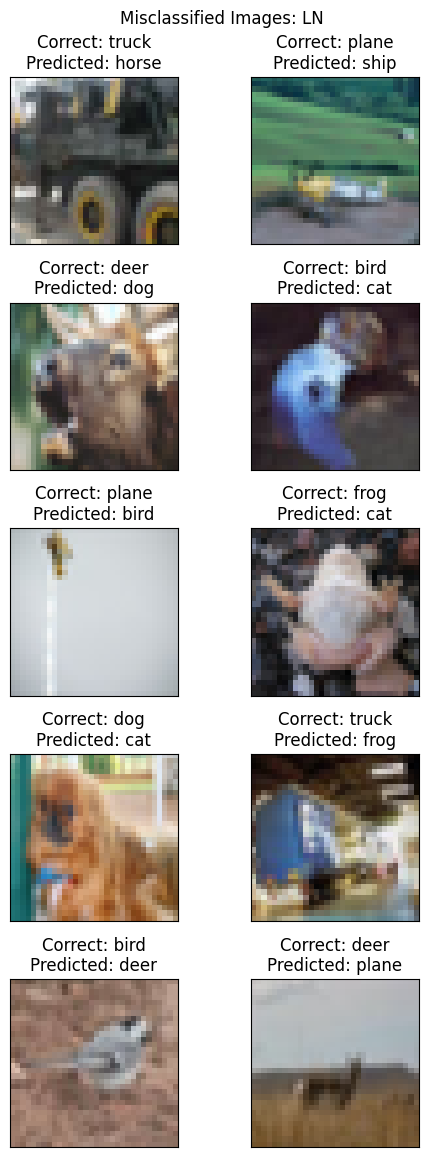

In [20]:
show_misclassified_images(
    misclassified_images[:10],
    predictions[:10],
    labels[:10],
    cifar10.classes,
    "Misclassified Images: LN",
)

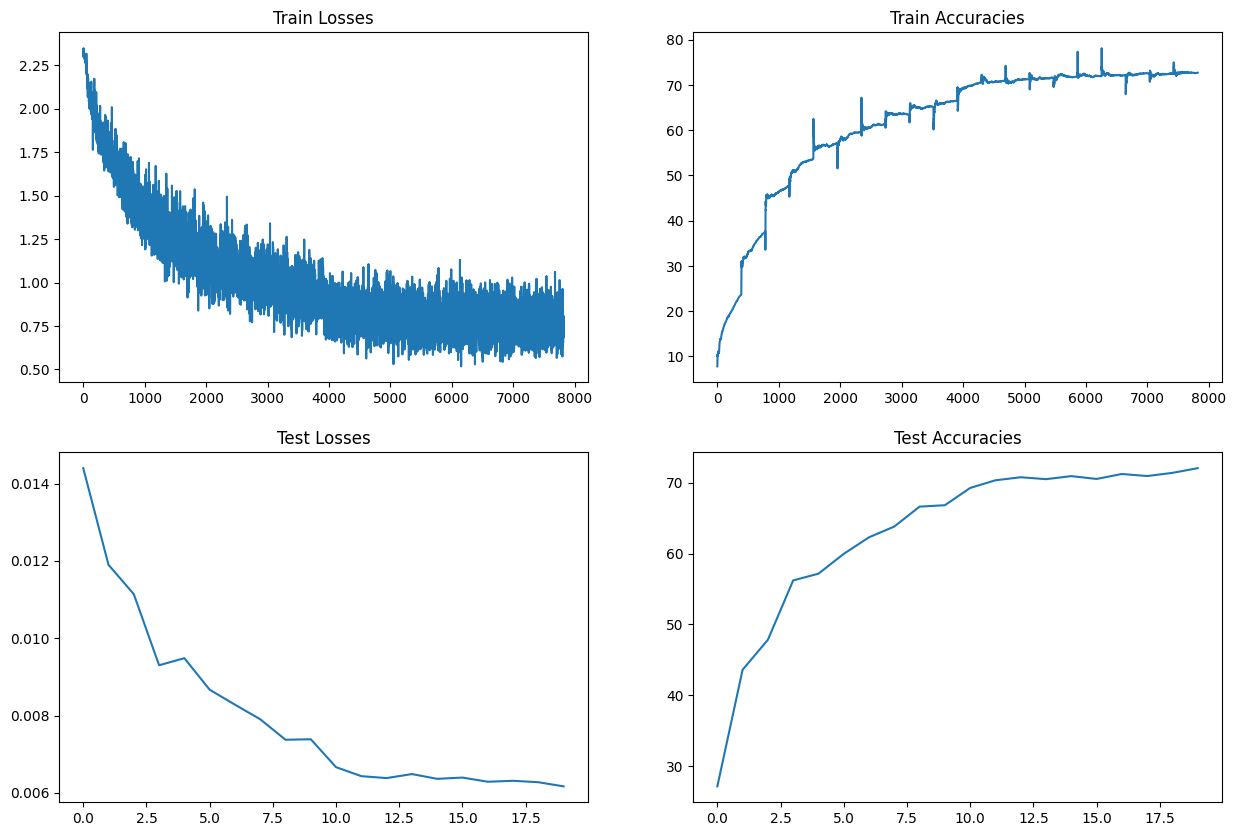

In [21]:
results = collect_results(trainer, tester)

plot_data(
    [
        results["train_losses"],
        results["train_accuracies"],
        results["test_losses"],
        results["test_accuracies"],
    ],
    [
        "Train Losses",
        "Train Accuracies",
        "Test Losses",
        "Test Accuracies",
    ],
)